# Machine Learning in Crowd Modelling and Simulation
# Final Project
# Task 4: Extended Dynamic Model Decomposition - Limit Cycle

### Group M:
1. Muhammad Waleed Bin Khalid
2. Qais Hamarneh
3. Yiming Zhang

# Useful Imports

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import scipy
from EDMD import EDMD
from tqdm import tqdm
from Observables import *
from utils import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## The Limit Cycle

$$
\begin{array}{r}
\dot{y}_{0}=-y_{1}+y_{0}\left(\mu-y_{0}^{2}-y_{1}^{2}\right) \\
\dot{y}_{1}=y_{0}+y_{1}\left(\mu-y_{0}^{2}-y_{1}^{2}\right)
\end{array}
$$

In [11]:
def limit_cycle(t, y):
    """ODE system."""
    mu = 1
    y_dot = np.zeros(2)

    factor = mu - y[0] ** 2 - y[1] ** 2

    y_dot[0] = -y[1] + y[0] * factor
    y_dot[1] = y[0] + y[1] * factor
    return y_dot

In [12]:
t_eval = np.linspace(0, 0.4, 21)

initial_conditions = np.array(
    np.meshgrid(np.linspace(-2, 2, 8), np.linspace(-2, 2, 8))
).T.reshape(-1, 2)
solution_df = pd.DataFrame()

for index, ic in enumerate(initial_conditions):
    solution = solve_ivp(limit_cycle, t_span=(t_eval[0], t_eval[-1]), y0=ic, t_eval=t_eval)
    solution_x = pd.DataFrame(data=solution["y"][:,:-1].T, columns=["x1", "x2"])
    solution_y = pd.DataFrame(data=solution["y"][:,1:].T, columns=["y1", "y2"])
    combined_df = pd.concat([solution_x, solution_y], axis=1)
    combined_df.insert(0, 'ID', index)
    solution_df = pd.concat([solution_df, combined_df])

Text(0, 0.5, 'y')

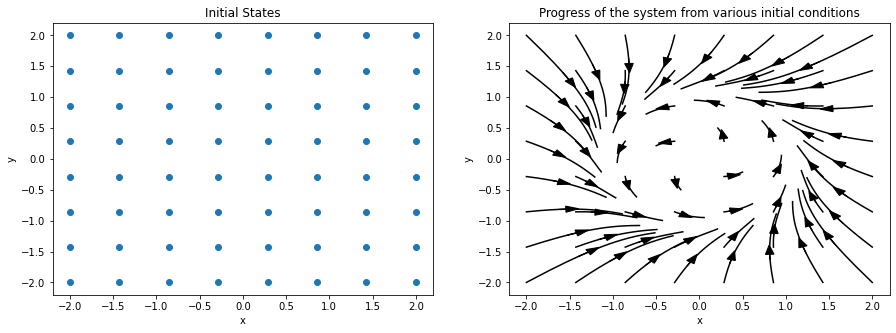

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].scatter(initial_conditions[:,0], initial_conditions[:,1])
axs[0].set_title('Initial States')
axs[0].set_xlabel('x'); axs[0].set_ylabel('y')
plot_data(solution_df, axs[1])
axs[1].set_title('Progress of the system from various initial conditions')
axs[1].set_xlabel('x'); axs[1].set_ylabel('y')
# fig.savefig('figures/limit_cycle_analytical.png')

## Using Identity Observables

In [14]:
identity_observables = Identity() # We will use the Hermite Pair dictionary as observables
identity_observables.fit(solution_df.iloc[:,0:3])

,ID,x1,x2,x1,x2
0,0,-2.000000,-2.000000,-2.000000,-2.000000
1,0,-1.735789,-1.806650,-1.735789,-1.806650
2,0,-1.547156,-1.676108,-1.547156,-1.676108
3,0,-1.401879,-1.581086,-1.401879,-1.581086
4,0,-1.286003,-1.510061,-1.286003,-1.510061
...,...,...,...,...,...
15,63,0.647749,1.227456,0.647749,1.227456
16,63,0.612206,1.218410,0.612206,1.218410
17,63,0.578201,1.210363,0.578201,1.210363
18,63,0.545490,1.203096,0.545490,1.203096


In [15]:
dmd = EDMD(solution_df, 2, identity_observables)
dmd.fit()
A = (dmd.koopman_matrix() - np.eye(2))/ 0.02
print(f"K={dmd.koopman_matrix()}")
print(f"A={A}")
print(f"Determinant of governing A matrix is {np.linalg.det(A).real:0.5f}")
print(f"Trace of governing A matrix is {np.trace(A).real:0.5f}")
print(f"Eigenvalues of A are {np.linalg.eig(A)[0]}")

K=[[ 0.97191225-3.98156799e-19j  0.01942801-6.83518986e-18j]
 [-0.01942801+1.76344550e-17j  0.97191225-6.25639627e-19j]]
A=[[-1.40438752-1.99078400e-17j  0.97140048-3.41759493e-16j]
 [-0.97140048+8.81722751e-16j -1.40438752-3.12819814e-17j]]
Determinant of governing A matrix is 2.91592
Trace of governing A matrix is -2.80878
Eigenvalues of A are [-1.40438752+0.97140048j -1.40438752-0.97140048j]


In [16]:
x_actual = solution_df[solution_df['ID'] == 1].iloc[:,:3]
initial_values = pd.DataFrame(initial_conditions, columns=['x1', 'x2'])
initial_values.insert(0, 'ID', range(len(initial_values)))
x_predict_dmd = dmd.predict(initial_values, t_end=20)
x_predict_dmd

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:08<00:00,  7.64it/s]


,ID,x1,x2
0,0.0,-2.000000,-2.000000
1,1.0,-2.000000,-1.428571
2,2.0,-2.000000,-0.857143
3,3.0,-2.000000,-0.285714
4,4.0,-2.000000,0.285714
...,...,...,...
0,63.0,0.807571,1.607252
0,63.0,0.753662,1.577797
0,63.0,0.701840,1.548122
0,63.0,0.652050,1.518274


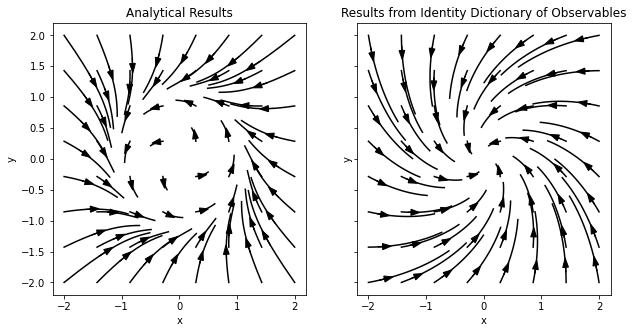

In [17]:
fig, axs = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10,5))
plot_data(solution_df, axs[0])
plot_data(x_predict_dmd, axs[1])
axs[0].set_title('Analytical Results')
axs[0].set_xlabel('x'); axs[0].set_ylabel('y')
axs[1].set_title('Results from Identity Dictionary of Observables')
axs[1].set_xlabel('x'); axs[1].set_ylabel('y')
fig.savefig('figures/limit_cycle_dmd_sol.png')

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.65it/s]


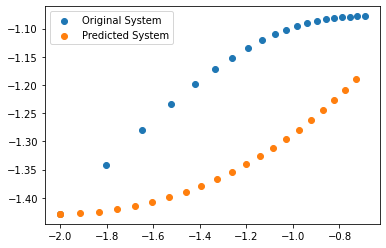

In [18]:
x_actual = solution_df[solution_df['ID'] == 1].iloc[:,:3]
initial_values = x_actual.iloc[0:1,0:3]
x_predict = dmd.predict(initial_values, t_end=20)
fig, axs = plt.subplots(1,1, sharex=True, sharey=True)
axs.scatter(x_actual.iloc[:,1].to_numpy().real, x_actual.iloc[:,2].to_numpy().real, label='Original System')
axs.scatter(x_predict.iloc[:,1].to_numpy().real, x_predict.iloc[:,2].to_numpy(), label='Predicted System')
plt.legend()

In [19]:
diff = x_actual.iloc[:,1:].to_numpy() - x_predict.iloc[1:-1,1:].to_numpy()
mse = np.sum(diff**2)
print(f"MSE for test trajectory is {mse}")

MSE for test trajectory is 1.6275333133019918


## Polynomial Dictionary

In [30]:
polynomial_observables = Polynomials(3)
polynomial_observables.segregate_observables_from_variable(polynomial_observables.fit(solution_df.iloc[:,0:3]))
# polynomial_observables.fit(solution_df.iloc[:,0:3])

,ID,x1^0x2^1,x1^0x2^2,x1^0x2^3,x1^1x2^0,x1^1x2^1,x1^1x2^2,x1^2x2^0,x1^2x2^1,x1^3x2^0
0,0,-2.000000,4.000000,-8.000000,-2.000000,4.000000,-8.000000,4.000000,-8.000000,-8.000000
1,0,-1.806650,3.263986,-5.896881,-1.735789,3.135963,-5.665589,3.012962,-5.443370,-5.229866
2,0,-1.676108,2.809339,-4.708757,-1.547156,2.593201,-4.346485,2.393691,-4.012086,-3.703414
3,0,-1.581086,2.499832,-3.952449,-1.401879,2.216491,-3.504462,1.965264,-3.107252,-2.755063
4,0,-1.510061,2.280283,-3.443365,-1.286003,1.941942,-2.932450,1.653802,-2.497342,-2.126794
...,...,...,...,...,...,...,...,...,...,...
15,63,1.227456,1.506648,1.849343,0.647749,0.795083,0.975929,0.419578,0.515014,0.271781
16,63,1.218410,1.484522,1.808757,0.612206,0.745917,0.908833,0.374796,0.456655,0.229452
17,63,1.210363,1.464978,1.773154,0.578201,0.699833,0.847052,0.334317,0.404644,0.193302
18,63,1.203096,1.447439,1.741407,0.545490,0.656277,0.789563,0.297559,0.357992,0.162316


## Fitting EDMD with Polynomial Dictionary of Observables

In [24]:
edmd = EDMD(solution_df, 2, polynomial_observables)
edmd.fit()

In [25]:
x_actual = solution_df[solution_df['ID'] == 1].iloc[:,:3]
initial_values = pd.DataFrame(initial_conditions, columns=['x1', 'x2'])
initial_values.insert(0, 'ID', range(len(initial_values)))

In [26]:
x_predict = edmd.predict(initial_values, t_end=20)
x_predict

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:31<00:00,  2.00it/s]


,ID,x1,x2
0,0.0,-2.000000,-2.000000
1,1.0,-2.000000,-1.428571
2,2.0,-2.000000,-0.857143
3,3.0,-2.000000,-0.285714
4,4.0,-2.000000,0.285714
...,...,...,...
0,63.0,0.618024,1.222484
0,63.0,0.583825,1.213943
0,63.0,0.550947,1.206165
0,63.0,0.519233,1.199024


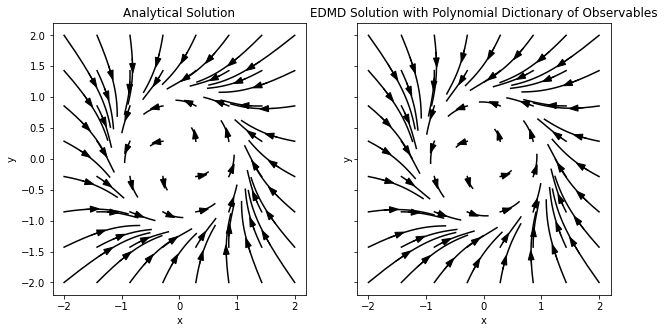

In [27]:
fig, axs = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)
plot_data(solution_df, axs[0])
plot_data(x_predict, axs[1])
axs[0].set_title('Analytical Solution')
axs[0].set_xlabel('x'); axs[0].set_ylabel('y'); 
axs[1].set_title('EDMD Solution with Polynomial Dictionary of Observables')
axs[1].set_xlabel('x'); axs[1].set_ylabel('y'); 
# fig.savefig('figures/limit_cycle_edmd_sol.png')

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.39it/s]


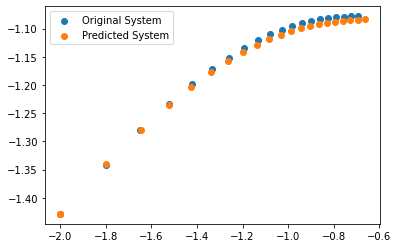

In [28]:
x_actual = solution_df[solution_df['ID'] == 1].iloc[:,:3]
initial_values = x_actual.iloc[0:1,0:3]
x_predict = edmd.predict(initial_values, t_end=20)
fig, axs = plt.subplots(1,1, sharex=True, sharey=True)
axs.scatter(x_actual.iloc[:,1].to_numpy().real, x_actual.iloc[:,2].to_numpy().real, label='Original System')
axs.scatter(x_predict.iloc[:,1].to_numpy().real, x_predict.iloc[:,2].to_numpy(), label='Predicted System')
plt.legend()

In [29]:
diff = x_actual.iloc[:,1:].to_numpy() - x_predict.iloc[1:-1,1:].to_numpy()
mse = np.sum(diff**2)
print(f"MSE for test trajectory is {mse}")

MSE for test trajectory is 0.001265165553366428
